# From ACS Download to Gif 

> In this tutorial, we run the full gambit, from downloading acs data to creating map gifs across several years of data

This Coding Notebook is the __fifth__ in a series.

Interactive examples are provided along the way.

This colab and more can be found at https://github.com/BNIA/colabs

- Content covered in previous tutorials will be used in later tutorials. 

- __new code and or  information *should* have explanations and or descriptions__ attached. 

- Concepts or code covered in previous tutorials will be used without being explaining in entirety.

- __If content can not be found in the current tutorial and is not covered in previous tutorials, please let me know.__

## Introduction

In this colab 
1. We will programmatically download data from the American Community Survey (ACS)
- - ACS data are estimates come from survey respondents across 5 year 
- - ACS data comes in at a tract level geographic granularity
- - Our examples will primarily use table B19001, Baltimore City 2017 estimates
2. We will rework the datasets to be human friendly
3. We will create Vital Signs Indicators from calculations using these datasets 
4. We will create convenience functions to wrap up everything we have learnt

Median Household Income is just one of the many operations that may perfrom on the data using publicly available code found in our github codebase. 

This colab and more can be found at https://gist.github.com/bniajfi

Developers Resource: https://www.census.gov/developers/

ACS API: https://www.census.gov/data/developers/data-sets.html

__*please note__

- A table of contents is provided in the menu to the left.
- And, that this notebook has been optimized for Google Colabs ran on a Chrome Browser. 
- While still fully usable, non-critical section of code (eg. Python Magics and HTML) may break if used in a different enviornment.

## About The Census Data

**Census and ACS Boundary Terminology**:

 Each of the bolded words in the content below are identifiable through a Geographic Reference Code. 
 
- A census block is the smallest unit of measurement used by the Census
- Information by census **block** is only available decenially (i.e. not ACS data)
- **Block groups** are the next smallest unit of measurement used by the census and are composed of aggregate census blocks
- Census **tracts** are composed of block groups and are the next largest unit of measurement used by the ACS
- **County**, **city** and census **designated places** are composed of Tracts

For more information on Geographic Reference Codes, refer to the table of contents for the section on that matter.

## Lets Get Started:

**Instructions:** Read all text and execute all code in order.  

**How to execute code:**

- Locate labels taking the form: 'Run This Cell: (descriptionOfFunction)'
- Left of this text you will see an open bracket [ ], possibly with a number inside it.
- - Hovering over the brackets will reveal a play button. Click the button to execute code.

To see the code you are executing, double click the label.



In [0]:
#@title Run This Cell: View User Path (html)

# This box uses HTML magic '%%html' to denote 
# that anything after that tag will be in HTML not Python.
# Within the HTML I use Javascript magic to render 
# a graph from the markup written inside the html div
# The graph maps out the possible paths 
# you may take when using this notebook.

%%html
<script src="https://code.jquery.com/jquery-1.10.2.js"></script>
<script src="https://unpkg.com/mermaid@7.1.0/dist/mermaid.min.js"> </script>
<script> window.mermaid.init() </script>
<h1> User Path </h1>
<div class="mermaid">
  graph LR
      User>User] --> ExploreAcsTables
      ExploreAcsTables --> DownloadAcsTable
      DownloadAcsTable -- Repeat --> DownloadAcsTable
      DownloadAcsTable --> DecideWhatToDo{DecideWhatToDo}
      DecideWhatToDo --> RunAnotherNotebook{RunAnotherNotebook} 
      DecideWhatToDo --> FinishTheNotebook
      RunAnotherNotebook --> MergeDatasets
      RunAnotherNotebook --> ExploreDataset
      RunAnotherNotebook --> QueryDataset
      FinishTheNotebook --> RetrieveCrosswalk
      RetrieveCrosswalk --> MergeCrosswalkToDatatable
      MergeCrosswalkToDatatable --> RunMedianHouseholdIndicator
</div>
  

# Import Python Modules

You will need to run this next box first in order for any of the code after it to work

In [0]:
#@title Run This Cell: Import Modules

# Install the Widgets Module. 
# Colabs does not locally provide this Python Library
# The '!' is a special prefix used in colabs when talking to the terminal
!pip install -U -q ipywidgets
!pip install geopandas

# Once installed we need to import and configure the Widgets
import ipywidgets as widgets
!jupyter nbextension enable --py widgetsnbextension
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Used 4 Importing Data
import urllib.request as urllib 
from urllib.parse import urlencode 
# This Prevents Timeouts when Importing
import socket 
socket.setdefaulttimeout(10.0)

# Pandas Data Manipulation Libraries
import pandas as pd
# Show entire column widths
pd.set_option('display.max_colwidth', -1)
# 4 Working with Json Data
import json 
# 4 Data Processing
import numpy as np
# 4 Reading Json Data into Pandas
from pandas.io.json import json_normalize

# 4 exporting data as CSV
import csv


# Geo-Formatting
# Postgres-Conversion
import geopandas as gpd
from geopandas import GeoDataFrame
import psycopg2,pandas,numpy
from shapely import wkb
from shapely.wkt import loads
import os
import sys

# In case file is KML
import fiona
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default

# https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2010.html
# https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Census+Tracts

# load libraries
#from shapely.wkt import loads
#from pandas import ExcelWriter
#from pandas import ExcelFile
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import imageio

# Explore Table Directories

The Census bureau provides 4 distinct dataset types: Detailed Tables, Subject Tables, Data Profiles, Comparison Profiles

We will only be explore the Detailed and Subject tables in this section

## Explore the Detailed Table Directory

Retrieve and search available ACS datasets through the ACS's table directory. 

The table directory contains TableId's and Descriptions for each datatable the ACS provides.

By running the next cell, an interactive searchbox will filter the directory for keywords within the description.

Be sure to grab the TableId once you find a table with a description of interest.

In [0]:
#@title Run This Cell: Import Dataset Directory

pd.set_option('display.max_columns', None)

url = 'https://api.census.gov/data/2017/acs/acs5/groups/'
response = urllib.urlopen(url)
data = json.loads(response.read())
data = data['groups']
metaDataTable = json_normalize(data)
metaDataTable.set_index('name', drop=True, inplace=True)


#--------------------
# SEARCH BOX 1: This reliably produces a searhbox. 
# The ell must be reran for every query.
#--------------------
description = input("Search ACS Table Directory by Keyword: ")
metaDataTable[ metaDataTable['description'].str.contains(description.upper()) ]

#--------------------
# SEARCH BOX 2: FOR CHROME USERS: 
# Commenting out the code above and running the code 
# below will update the searchbox in real time.
#--------------------
# @interact
# def tableExplorer(description='family'): 
#  return metaDataTable[ metaDataTable['description'].str.contains(description.upper()) ]

Once you a table from the explorer has been picked, you can inspect its column names in the next part. 

This will help ensure it has the data you need!

In [0]:
#@title Run This Cell: Interactive Table Lookup

import json 
import pandas as pd 
from pandas.io.json import json_normalize

pd.set_option('display.max_columns', None)
#--------------------
# SEARCH BOX 1: This reliably produces a searchbox. 
# The ell must be reran for every query.
#--------------------
tableId = input("Please enter a Table ID to inspect: ")

url = f'https://api.census.gov/data/2017/acs/acs5/groups/{tableId}.json'
metaDataTable = pd.read_json(url)

metaDataTable.reset_index(inplace = True, drop=False) 
metaDataTable = pd.merge(json_normalize(data=metaDataTable['variables']), metaDataTable['index'] , left_index=True, right_index=True)
metaDataTable = metaDataTable[['index', 'concept']]
metaDataTable = metaDataTable.dropna(subset=['concept'])
metaDataTable.head()

## Explore the Subject Table Directory

The Data Structure we recieve is different than the prior table. 

Intake and processing is different as a result

Now lets explore what we got, just like before. 

Only difference is that the column names are automatically included in this query.

In [0]:
#@title Run This Cell: Interactive Dataset Directory


# Note the json representation
url = 'https://api.census.gov/data/2017/acs/acs5/subject/variables.json'
response = urllib.urlopen(url)
# Decode the url response as json
# https://docs.python.org/3/library/json.html
data = json.loads(response.read())
# the json object contains all its information within attribute 'variables' 
data = data['variables']

# Process  by flattening the raw json data
objArr = []
for key, value in data.items():
  value['name'] = key
  objArr.append(value)

# Normalize semi-structured JSON data into a flat table.
metaDataTable = json_normalize(objArr)
# Set the column 'name' as an index.
metaDataTable.set_index('name', drop=True, inplace=True)
# Reduce the directory to only contain these attributes
metaDataTable = metaDataTable[ ['attributes', 'concept', 'group', 'label', 'limit', 'predicateType' ] ]



#--------------------
# SEARCH BOX 1: This reliably produces a searhbox. 
# The ell must be reran for every query.
#--------------------
concept = input("Search ACS Subject Table Directory by Keyword")
metaDataTable[ metaDataTable['concept'].str.contains(concept.upper(), na=False) ]

#--------------------
# SEARCH BOX 2: FOR CHROME USERS: 
# Commenting out the code above and running the code 
# below will update the searchbox in real time.
#--------------------
#@interact
#def subjectExplorer(concept='transport'): 
#  return metaDataTable[ metaDataTable['concept'].str.contains(concept.upper(), na=False) ]

# Geographic Reference Codes

In order to successfully pull data, a Census State and County Code must be provided.

The code herin is configured by default to pull data on Baltimore City, MD and its constituent Tracts.

**In order to find your State and County code:**

------------------------------------------------------
Either 

A)  Click the link: https://geocoding.geo.census.gov/geocoder/geographies/address where upon entering a unique address you can locate state and county codes under the associated values 'Counties' and 'State' 

OR

B) Conversly, click https://www.census.gov/geographies/reference-files/time-series/geo/tallies.html
- The Geographies mainpage contains a lot of data assets.
- The link to these tallies was located by accessing the geographical references subdirectory of the geographies mainpage and then filtered for publications made on the year 2010 (We are using the 2010 census boundaries)
- Once clicked, simply scroll down to where you find the header 'Tallies of Geographic Entities By State'
- Enter your state and press enter.
- You will be redirected to a plain text file that will contain all the information on your state and its counties. 
------------------------------------------------------

# Get Table Data

Hopefully, by now you know which data table you would like to download!

This next section will do that for you.  

Running the cells below will will 'Create' our download function

Function Notes (In depth notes are provided as comments in the code): 

- This is the function that will retrieve the datatables!

- Accepts parameters (state, county, tract, tableId, year, saveAcs)

- Before we retrieve the actual data, we want the table's metadata. 

- This metadata will be used as a crosswalk to replace the awkward column names

- If this is not done, only a column ID would denote each column. not human readable.

- County totals are included automatically as 'tract 010000'. 

- The County total is not the sum of all other tracts but a seperate, indendent and unique query.

- Finally, we will download the data in two different formats if desired.

- If we choose to save the data, we save it with the Table IDs + ColumnNames, and once without the TableIDs.

In [0]:
# @title Run This Cell: Create retrieve_acs_data()

#File: retrieveAcsData.py
#Author: Charles Karpati
#Date: 1/9/19
#Section: Bnia
#Email: karpati1@umbc.edu
#Description:
#This file returns ACS data given an ID and Year
# The county total is given a tract of '010000'

#def main():
#purpose: Retrieves ACS data from the web
#input: ID
#output: Acs Data. Prints to ../../data/2_cleaned/acs/
dictionary = ''
def retrieve_acs_data(state, county, tract, tableId, year, saveAcs):
    keys = []
    vals = []
    header = []
    keys1=keys2=keys3=keys4=keys5=keys6=keys7=keys8=''
    keyCount = 0

    # Called in addKeys(), Will create the final URL for readIn()
    # These are parameters used in the API URL Query
    # This query will retrieve the census tracts
    def getParams(keys): return {
        'get': 'NAME'+keys,
        'for': 'tract:'+tract,
        'in': 'state:'+state+' county:'+county,
        'key': '829bf6f2e037372acbba32ba5731647c5127fdb0'
      }
    # Baltimore City data is best retrieved seperatly rather than as an aggregate of its constituent tracts
    def getBCityParams(keys): return {
        'get': 'NAME'+keys,
        'for': 'county:'+county,
        'in': 'state:'+state,
        'key': '829bf6f2e037372acbba32ba5731647c5127fdb0'
      }
    # Called in AddKeys(). Requests data by url and preformats it.
    def readIn( url ):
        tbl = pd.read_json(url, orient='records')
        tbl.columns = tbl.iloc[0]
        return tbl 

    # Called by retrieveAcsData. 
    # Creates a url and retrieve the data
    # Then appends the city values as tract '010000'
    # Finaly it merges and returns the tract and city totals.
    def addKeys( table, params):
        # Get Tract and City Records For Specific Columns
        table2 = readIn( base+urlencode(getParams(params)) )
        table3 = readIn( base+urlencode(getBCityParams(params)) )
        table3['tract'] = '010000'
        # Concatenate the Records
        table2.append([table2, table3], sort=False)
        table2 = pd.concat([table2, table3], ignore_index=True)
        # Merge to Master Table
        table = pd.merge(table, table2,  how='left', 
                         left_on=["NAME","state","county","tract"], 
                         right_on = ["NAME","state","county","tract"])
        return table
    
    #~~~~~~~~~~~~~~~
    # Step 1)
    # Retrieve a Meta Data Table Describing the Content of the Table
    #~~~~~~~~~~~~~~~
    url = 'https://api.census.gov/data/20'+year+'/acs/acs5/groups/'+tableId+'.json'
    metaDataTable = pd.read_json(url, orient='records')
    
    #~~~~~~~~~~~~~~~
    # Step 2)
    # Createa a Dictionary using the Meta Data Table
    #~~~~~~~~~~~~~~~
    # Multiple Queries may be Required.
    # Max columns returned from any given query is 50.
    # For that reasons bin the Columns into Groups of 50.
    for key in metaDataTable['variables'].keys():
      if key[-1:] == 'E':
        keyCount = keyCount + 1
        if keyCount < 40 : keys1 = keys1+','+key
        elif keyCount < 80 : keys2 = keys2+','+key
        elif keyCount < 120 : keys3 = keys3+','+key
        elif keyCount < 160 : keys4 = keys4+','+key
        elif keyCount < 200 : keys5 = keys5+','+key
        elif keyCount < 240 : keys6 = keys6+','+key
        elif keyCount < 280 : keys7 = keys7+','+key
        elif keyCount < 320 : keys8 = keys8+','+key
        keys.append(key)
        val = metaDataTable['variables'][key]['label']
        # Column name formatting
        val = key+'_'+val.replace('Estimate!!', '').replace('!!', '_').replace(' ', '_')
        vals.append(val)
    dictionary = dict(zip(keys, vals))
  
    #~~~~~~~~~~~~~~~
    # Step 2)
    # Get the actual Table with the data we want using 
    # the columns names obtained from the meta data table
    #~~~~~~~~~~~~~~~    
    
    # The URL we call is contingent on if the Table we want is a Detailed or Subject table
    url1 = 'https://api.census.gov/data/20'+year+'/acs/acs5?'
    url2 = 'https://api.census.gov/data/20'+year+'/acs/acs5/subject?'
    base = ''
    if tableId[:1] == 'B': base = url1 
    if tableId[:1] == 'S': base = url2
      
    # The addKey function only works after the first set of columns has been downloaded
    # Download First set of Tract columns
    url = base+urlencode(getParams(keys1) )
    table = pd.read_json(url, orient='records')
    table.columns = table.iloc[0]
    table = table.iloc[1:]
    # Download First set of Baltimore City data table columns
    url = base+urlencode(getBCityParams(keys1))
    table2 = pd.read_json(url, orient='records')
    table2.columns = table2.iloc[0]
    table2 = table2[1:]
    table2['tract'] = '010000'
    
    # Merge EM
    #table = pd.concat([table, table2], keys=["NAME","state","county",], axis=0)
    table.append([table, table2], sort=False)
    table = pd.concat([table, table2], ignore_index=True)
    
    # Now we can repetedly use this function to add as many columns as there are keys listed from the meta data table
    if keys2 != '' : table = addKeys(table, keys2)
    if keys3 != '' : table = addKeys(table, keys3)
    if keys4 != '' : table = addKeys(table, keys4)
    if keys5 != '' : table = addKeys(table, keys5)
    if keys6 != '' : table = addKeys(table, keys6)
    if keys7 != '' : table = addKeys(table, keys7)
    if keys8 != '' : table = addKeys(table, keys8)
      
    #~~~~~~~~~~~~~~~
    # Step 3)
    # Prepare Column Names using the meta data table. The raw data has columnsNames in the first row, as well.
    # Replace column ID's with labels from the dictionary where applicable (should be always)
    #~~~~~~~~~~~~~~~
    print('Number of Columns', len(dictionary) )

    header = []
    for column in table.columns:
        if column in keys: header.append(dictionary[column])
        else: header.append(column)
    table.columns = header

    # Prettify Names. Only happens with Baltimore...
    table['NAME'] = table['NAME'].str.replace(', Baltimore city, Maryland', '')
    table['NAME'][table['NAME'] == 'Baltimore city, Maryland'] = 'Baltimore City' 
    
    # Convert to Integers Columns from Strings where Applicable
    table = table.apply(pd.to_numeric, errors='ignore')
    
    # Set the 'NAME' Column as the index dropping the default increment
    table.set_index("NAME", inplace = True)
    
    if saveAcs:
      # Save the raw data as 'TABLEID_5yYEAR.csv'
      table.to_csv('./'+state+county+'_'+tableId+'_5y'+year+'_est_Original.csv', quoting=csv.QUOTE_ALL)
      # Remove the id in the column names & Save the data as 'TABLEID_5yYEAR_est.csv'
      saveThis = table.rename( columns = lambda x : ( str(x)[:] if str(x) in [
        "NAME","state","county","tract"] else str(x)[12:] )  )
      saveThis.to_csv('./'+state+county+'_'+tableId+'_5y'+year+'_est.csv', quoting=csv.QUOTE_ALL)

    return table

Now use this function to Download the Data!

In [0]:
# Our download function will use Baltimore City's tract, county and state as internal paramters
# Change these values in the cell below using different geographic reference codes will change those parameters
tract = '*'
county = '510'
state = '24'

# Specify the download parameters the function will receieve here
tableId = 'B19001'
year = '17'
saveAcs = True

In [0]:
df = retrieve_acs_data(state, county, tract, tableId, year, saveAcs)
df.head()

## Congratulations!

If you have gotten to this part, you have succesfully downloaded the ACS data.

The next parts have been put together to help you with basic ACS data handling tasks and play.

# CROSSWALK

- Crosswalks help translate the census tract ID's to something more human friendly 
- We also commonly use them to pass Boundary data to the datasets using the tract names as a bridge
- Bnia uses a crosswalk that map tract id's to Community Statistical Areas (CSA's)
- Community Statistical Areas (CSA's) were created using regional planning districts as reference 
- Regional planning districts were formed by the Baltimore Metropolitan Council (BMC) 


Before we create the Crosswalk function, lets make sure we have the data we will need for the function.

Just for giggles: I'm just going to load in the file we just created. This is kind of silly because when we called the retrieveAndCleanAcsData we stored the responce into a  variable 'df' (short for dataframe). When we read in the saved file, we are going to store it into that very same df variable. 

The 'read_csv' Function accepts a directory file path or a url. 


Please refer to the 'Connect to Drive' section to see how you access your google drive account as though it were a local directory.

In [0]:
# The data we just downloaded should be accessibly in your Google Local File Directory
#data = tableId+'_5y'+year+'_est.csv'
# cd ../../../../../content/drive/My Drive/colabs/DATA
data = state+county+'_'+tableId+'_5y'+year+'_est_Original.csv'
df = pd.read_csv( data )
df.columns

And now I will get a crosswalk. 

The crossswalk used in this example is from a google spreadsheet I made publically accessible via URL. 

I will print out the column names of this crosswalk too as it will come in handy right soon

In [0]:
# Publish a google spreadsheet to the web and it can be retrieved via URL here.
# Instructions to do this yoruself: https://support.google.com/docs/answer/183965?co=GENIE.Platform%3DDesktop&hl=en
baltimore = '2PACX-1vREwwa_s8Ix39OYGnnS_wA8flOoEkU7reIV4o3ZhlwYhLXhpNEvnOia_uHUDBvnFptkLLHHlaQNvsQE'
url = 'https://docs.google.com/spreadsheets/d/e/' + baltimore + '/pub?output=csv' 

# Match Tract to CSA
crosswalk = pd.read_csv( url )
crosswalk.columns

Now lets create our crosswalk function!

- If any record from our original dataset is not matched, we will be told which (so that we may fix it).
- The final returned dataset will have any unmatached records removed.
- It will save the dataset if desired and may take a filename or create its own.

In [0]:
#@title Run This Cell: Create mergeDatasets()

def mergeDatasets(df=False, cw=False, left_on=False, right_on=False, how=False, save=False, name=False ): 
    
    
  # Check if the columns actually exist
  def checkColumns(df, cw, left_on, right_on, how): 
    dfkeyexist = {left_on}.issubset(df.columns)
    cwkeyexist = {right_on}.issubset(cw.columns) 
    cscolexist = ( {how}.issubset(cw.columns) or 
                  how in ['left', 'right', 'outer', 'inner'] )

    print('df', dfkeyexist, 'cw', cwkeyexist, 'cs', cscolexist)
    
    return (dfkeyexist and cwkeyexist and cscolexist)

  # Ensure data types are the same
  def coerceDtypes(df, cw, left_on, right_on):
    status = False
    foreignDtype = cw[right_on].dtype
    localDtype = df[left_on].dtype  
    
    # Coerce one way or the other if possible
    if localDtype == 'int64' and foreignDtype == 'object':
      print('Converting Foreign Key from Object to Int' )
      cw[right_on] = pd.to_numeric(cw[right_on], errors='coerce')
      foreignDtype = cw[right_on].dtype
      
    if localDtype == 'object' and foreignDtype == 'int64':
      print('Converting Foreign Key from Object to Int' )
      df[left_on] = pd.to_numeric(df[left_on], errors='coerce')
      localDtype = df[left_on].dtype
      
    # Return the data and the coerce status
    if localDtype == foreignDtype: status = True
    return df, cw, status


  # Decide to perform a merge or commit a pull
  def mergeOrPull(df, cw, left_on, right_on, how):  
    
    def merge(df, cw, left_on, right_on, how):
      print('Merging', left_on, right_on, how); 
      df = pd.merge(df, cw, left_on=left_on, right_on=right_on, how=how)
      # df.drop(left_on, axis=1)
      df[right_on] = df[right_on].fillna(value='empty')
      return df

    def pull(df, cw, left_on, right_on, how):
      crswlk = dict(zip(cw[right_on], crosswalk[how]  ) )
      dtype = df[left_on].dtype
      # print('Pulling'); 
      # print('df.columns', left_on, df[left_on].dtype)
      # print('cw.columns', right_on, cw[right_on].dtype)
      # print('left_on', left_on, 'right_on', right_on, 'how', how)
      if dtype =='object':  df[how] = df.apply(lambda row: crswlk.get(str(row[left_on]), "empty"), axis=1)
      elif dtype == 'int64': 
        df[how] = df.apply(lambda row: crswlk.get(int(row[left_on]), "empty"), axis=1)
      return df
    
      #crswlk = dict(zip(crosswalk[foreign_tract_name], crosswalk[new_column_name]  ) )
      #if foreignDtype == 'object' and foreignDtype == 'object':
      #  temp[new_column_name] = temp.apply(lambda row: crswlk.get(str(row[local_tract_name]), "empty"), axis=1)
      #elif foreignDtype == 'int64' and foreignDtype == 'int64':
      #  temp[new_column_name] = temp.apply(lambda row: crswlk.get(int(row[local_tract_name]), "empty"), axis=1)
      #else: print('THERE BE PROBLEM')
    
    mergeType = how in ['left', 'right', 'outer', 'inner']
    if mergeType: return merge(df, cw, left_on, right_on, how)
    else: return pull(df, cw, left_on, right_on, how)
    
  
    
  # Filter between matched records and not.
  def filterEmpties(df, cw, left_on, right_on, how):
    
    if how in ['left', 'right', 'outer', 'inner']: how = right_on
    nomatch = df.loc[df[how] == 'empty']
    nomatch = nomatch.sort_values(by=left_on, ascending=True)
    
    if nomatch.shape[0] > 0:
      # Do the same thing with our foreign tracts
      print('Local Column Values Not Matched ')
      print(nomatch[left_on].unique() )
      print(len(nomatch[left_on]))
      print('')
      print('Crosswalk Unique Column Values')
      print(cw[right_on].unique() )
    
    # Create a new column with the tracts value mapped to its corresponding value from the crossswalk
    df[how].replace('empty', np.nan, inplace=True)
    df.dropna(subset=[how], inplace=True)
    # cw = cw.sort_values(by=how, ascending=True)
    return df

  # Save the data (again) as Cleaned for me to use in the next scripts
  def saveCrosswalk(save, fileName):
    if save: 
      print('SavingCrosswalk'); 
      if fileName: print(fileName); df.to_csv(fileName, quoting=csv.QUOTE_ALL)
      else: df.to_csv('./crosswalk-matched-'+left_on+'-to-'+right_on+'-pulling-'+how+'.csv', quoting=csv.QUOTE_ALL)

  def getMergeParams():

    df = pd.read_csv( input("Please enter the location of your left dataset: " ) )
    print( 'Left Columns ' + str(df.columns))

    crosswalk = pd.read_csv( input("Please enter the location of your right dataset: " ) )
    print( 'Right Columns ' + str(crosswalk.columns) + '\n')

    left_on = input("Left on: " )
    right_on = input("Right on: " )
    how = input("How: (‘left’, ‘right’, ‘outer’, ‘inner’, columnName) " )

    # Save the data
    saveFile = input("Save File ('Y' or 'N'): ")
    outFile = False
    if saveFile == 'Y' or saveFile == 'y':
      outFile = input("Saved Filename (Do not include the file extension ): ")

    return df, crosswalk, left_on, right_on, how, saveFile, outFile
    
    
  # This function uses all the other functions
  def main(df, cw, left_on, right_on, how, save, name):
    
    if ( (not isinstance(df, pd.DataFrame)) or (not isinstance(cw, pd.DataFrame)) 
        or not left_on or not right_on or not how): return crosswalkIt( *getMergeParams() );
    
    # Quit if the Columns dont exist
    status = checkColumns(df, cw, left_on, right_on, how)
    if status == False: print('A specified column does not exist'); return False;
    
    # Quit if the foreign key data types wont align nicely
    df, cw, status = coerceDtypes(df, cw, left_on, right_on);
    if status == False: print('Foreign keys data types do not match'); return False;
      
    # Perform the merge
    df = mergeOrPull(df, cw, left_on, right_on, how)    
    
    # Filter out columns not matched
    df = filterEmpties(df, cw, left_on, right_on, how)
    
    # Save this final result
    saveCrosswalk(save, name)
                      
    return df
  
  return main(df, cw, left_on, right_on, how, save, name)
# https://docs.google.com/spreadsheets/d/e/2PACX-1vTPKW6YOHPFvkw3FM3m5y67-Aa5ZlrM0Ee1Fb57wlGuldr99sEvVWnkej30FXhSb3j8o9gr8izq2ZRP/pub?output=csv
# https://docs.google.com/spreadsheets/d/e/2PACX-1vREwwa_s8Ix39OYGnnS_wA8flOoEkU7reIV4o3ZhlwYhLXhpNEvnOia_uHUDBvnFptkLLHHlaQNvsQE/pub?output=csv

Lets Crosswalk! We have an original dataset, the crosswalk dataset, 

In [0]:
local_match_col = 'tract'
foreign_match_col = 'TRACT2010'
foreign_wanted_col = 'CSA2010'
save=True, 
fileName='ExampleCrosswalkTest.csv'

In [0]:
crosswalkExample = mergeDatasets( df, crosswalk, local_match_col, foreign_match_col, foreign_wanted_col, save, fileName )
crosswalkExample.head()

Geographic data may be crosswalked as well. More information in the 'Maps' section.

# Creating BNIA Indictors

Awesome! 

By this point you should be able to download a dataset, and crosswalk new columns onto it by matching on 'tract'

What we are going to do now is perform calculations using these newly created datasets.

Run the next few cells to create our calculatory functions

In [0]:
#@title Run This Cell: Misc Function Declarations
# These functions right here are used in the calculations below.
# Finds a column matchings a substring
def getColName  (df, col): return df.columns[df.columns.str.contains(pat = col)][0] 
def getColByName (df, col): return df[getColName(df, col)]

# Pulls a column from one dataset into a new dataset. 
# This is not a crosswalk. calls getColByName() 
def addKey(df, fi, col):
    key = getColName(df, col)
    val = getColByName(df, col)
    fi[key] = val
    return fi
# Return 0 if two specified columns are equal.
def nullIfEqual(df, c1, c2): 
    return df.apply(lambda x: 
        x[getColName(df, c1)]+x[getColName(df, c2)] if x[getColName(df, c1)]+x[getColName(df, c2)] != 0 else 0, axis=1)
# I'm thinking this doesnt need to be a function..
def sumInts(df): return df.sum(numeric_only=True)

In [0]:
# @title Run This Cell : Create MHHI

#File: mhhi.py
#Author: Charles Karpati
#Date: 1/24/19
#Section: Bnia
#Email: karpati1@umbc.edu
#Description: 
# Uses ACS Table B19001 - HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS)
# Universe: Households
# Table Creates: hh25 hh40 hh60 hh75 hhm75, mhhi
#purpose: Produce Sustainability - Percent of Population that Walks to Work Indicator
#input:
#output:
import pandas as pd
import glob

def mhhi( df, columnsToInclude = [] ):
  #~~~~~~~~~~~~~~~
  # Step 2)
  # Prepare the columns
  #~~~~~~~~~~~~~~~ 
  info = pd.DataFrame(
      [
          ['B19001_002E', 0, 10000],
          ['B19001_003E', 10000, 4999 ],
          ['B19001_004E', 15000, 4999 ],
          ['B19001_005E', 20000, 4999 ],
          ['B19001_006E', 25000, 4999 ],
          ['B19001_007E', 30000, 4999],
          ['B19001_008E', 35000, 4999 ],
          ['B19001_009E', 40000, 4999 ],
          ['B19001_010E', 45000, 4999 ],
          ['B19001_011E', 50000, 9999 ],
          ['B19001_012E', 60000, 14999],
          ['B19001_013E', 75000, 24999 ],
          ['B19001_014E', 100000, 24999 ],
          ['B19001_015E', 125000, 24999 ],
          ['B19001_016E', 150000, 49000 ],
          ['B19001_017E', 200000, 1000000000000000000000000 ],

      ], 
      columns=['variable', 'lower', 'range']
  )

  # Final Dataframe  
  data_table = pd.DataFrame()
  for index, row in info.iterrows():
      data_table = addKey(df, data_table, row['variable'])

  # Accumulate totals accross the columns.
  # Midpoint: Divide column index 16 (the last column) of the cumulative totals
  temp_table = data_table.cumsum(axis=1)
  temp_table['midpoint'] = (temp_table.iloc[ : , -1 :] /2) # V3
  temp_table['midpoint_index'] = False
  temp_table['midpoint_index_value'] = False # Z3
  temp_table['midpoint_index_lower'] = False # W3 
  temp_table['midpoint_index_range'] = False # X3
  temp_table['midpoint_index_minus_one_cumulative_sum'] = False #Y3
  # step 3 - csa_agg3: get the midpoint index by "when midpoint > agg[1] and midpoint <= agg[2] then 2"

  # Get CSA Midpoint Index using the breakpoints in our info table.
  for index, row in temp_table.iterrows():
      # Get the index of the first column where our midpoint is greater than the columns value.
      midpoint = row['midpoint']
      midpoint_index = 0
      # For each column (except the 6 columns we just created)

      # The tracts midpoint was < than the first tracts value at column 'B19001_002E_Total_Less_than_$10,000'
      if( midpoint < int(row[0]) or row[-6] == False ):
        temp_table.loc[ index, 'midpoint_index' ] = 0
      else:
        for column in row.iloc[:-6]:
            # set midpoint index to the column with the highest value possible that is under midpoint          
            if( midpoint >= int(column) ):
                if midpoint==False: print (str(column) + ' - ' + str(midpoint))
                temp_table.loc[ index, 'midpoint_index' ] = midpoint_index +1
            midpoint_index += 1

  # temp_table = temp_table.drop('Unassigned--Jail')
  for index, row in temp_table.iterrows(): 
    temp_table.loc[ index, 'midpoint_index_value' ] = data_table.loc[ index, data_table.columns[row['midpoint_index']] ]
    temp_table.loc[ index, 'midpoint_index_lower' ] = info.loc[ row['midpoint_index'] ]['lower']     
    temp_table.loc[ index, 'midpoint_index_range' ] = info.loc[ row['midpoint_index'] ]['range']
    temp_table.loc[ index, 'midpoint_index_minus_one_cumulative_sum'] = row[ row['midpoint_index']-1 ]

  # This is our denominator, which cant be negative.
  for index, row in temp_table.iterrows():
    if row['midpoint_index_value']==False: 
      temp_table.at[index, 'midpoint_index_value']=1;
      
  #~~~~~~~~~~~~~~~
  # Step 3)
  # Run the Calculation 
  # Calculation = (midpoint_lower::numeric + (midpoint_range::numeric * ( (midpoint - midpoint_upto_agg) / nullif(midpoint_total,0)
  # Calculation = W3+X3*((V3-Y3)/Z3)

  # v3 -> 1 - midpoint of households  == sum / 2
  # w3 -> 2 - lower limit of the income range containing the midpoint of the housing total == row[lower]
  # x3 -> width of the interval containing the medium == row[range]
  # z3 -> number of hhs within the interval containing the median == row[total] 
  # y3 -> 4 - cumulative frequency up to, but no==NOT including the median interval
  #~~~~~~~~~~~~~~~

  def finalCalc(x):
    return ( x['midpoint_index_lower']+ x['midpoint_index_range']*(
      ( x['midpoint']-x['midpoint_index_minus_one_cumulative_sum'])/ x['midpoint_index_value'] ) 
    )

  temp_table['final'] = temp_table.apply(lambda x: finalCalc(x), axis=1)
  
  
  columnsToInclude.append('tract')
  print ('INCLUDING COLUMN(s):' + str(columnsToInclude))
  temp_table[columnsToInclude] = df[columnsToInclude]
  #~~~~~~~~~~~~~~~
  # Step 4)
  # Add Special Baltimore City Data
  #~~~~~~~~~~~~~~~  
  # url = 'https://api.census.gov/data/20'+str(year)+'/acs/acs5/subject?get=NAME,S1901_C01_012E&for=county%3A510&in=state%3A24&key=829bf6f2e037372acbba32ba5731647c5127fdb0'
  # table = pd.read_json(url, orient='records')
  # temp_table['final']['Baltimore City'] = float(table.loc[1, table.columns[1]])
    
  return temp_table

In [0]:
#@title Run This Cell: Create trav45

#File: trav45.py
#Author: Charles Karpati
#Date: 1/17/19
#Section: Bnia
#Email: karpati1@umbc.edu
#Description: 
# Uses ACS Table B08303 - TRAVEL TIME TO WORK,
# (Universe: Workers 16 years and over who did not work at home) 
# Table Creates: trav14, trav29, trav44, trav45
#purpose: Produce Sustainability - Percent of Employed Population with Travel Time to Work of 45 Minutes and Over Indicator
#input: 
#output: 

import pandas as pd
import glob
def trav45(df, columnsToInclude = [] ):
    #~~~~~~~~~~~~~~~
    # Step 2)
    # Prepare the columns
    #~~~~~~~~~~~~~~~ 

    # Final Dataframe  
    fi = pd.DataFrame()
    columns = ['B08303_011E','B08303_012E','B08303_013E','B08303_001E', 'tract'] 
    columns.extend(columnsToInclude)
    for col in columns:
        fi = addKey(df, fi, col)

    # Numerators 
    numerators = pd.DataFrame()
    columns = ['B08303_011E','B08303_012E','B08303_013E']
    for col in columns:
        numerators = addKey(df, numerators, col)
    
    # Denominators
    denominators = pd.DataFrame()
    columns = ['B08303_001E']
    for col in columns:
        denominators = addKey(df, denominators, col)
    # construct the denominator, returns 0 iff the other two rows are equal.

    #~~~~~~~~~~~~~~~
    # Step 3)
    # Run the Calculation 
# ( (value[1] + value[2] + value[3] ) / nullif(value[4],0) )*100
    #~~~~~~~~~~~~~~~
    fi['numerator'] = numerators.sum(axis=1)
    fi['denominator'] = denominators.sum(axis=1)
    fi = fi[fi['denominator'] != 0] # Delete Rows where the 'denominator' column is 0
    fi['final'] = (fi['numerator'] / fi['denominator'] ) * 100
    
    return fi

In [0]:
#@title Run This Cell: Create trav44

#File: trav44.py
#Author: Charles Karpati
#Date: 1/17/19
#Section: Bnia
#Email: karpati1@umbc.edu
#Description: 
# Uses ACS Table B08303 - TRAVEL TIME TO WORK,
# (Universe: Workers 16 years and over who did not work at home)
# Table Creates: trav14, trav29, trav44, trav45
#purpose: Produce Sustainability - Percent of Employed Population with Travel Time to Work of 30-44 Minutes Indicator
#input: 
#output: 

import pandas as pd
import glob
def trav44( df, columnsToInclude = [] ):
    #~~~~~~~~~~~~~~~
    # Step 2)
    # Prepare the columns
    #~~~~~~~~~~~~~~~ 

    # Final Dataframe  
    fi = pd.DataFrame()
    columns = ['B08303_008E','B08303_009E','B08303_010E','B08303_001E', 'tract'] 
    columns.extend(columnsToInclude) 
    for col in columns:
        fi = addKey(df, fi, col)

    # Numerators 
    numerators = pd.DataFrame()
    columns = ['B08303_008E','B08303_009E','B08303_010E']
    for col in columns:
        numerators = addKey(df, numerators, col)
    
    # Denominators
    denominators = pd.DataFrame()
    columns = ['B08303_001E']
    for col in columns:
        denominators = addKey(df, denominators, col)
    # construct the denominator, returns 0 iff the other two rows are equal.

    #~~~~~~~~~~~~~~~
    # Step 3)
    # Run the Calculation 
    # ( (value[1] + value[2] + value[3] ) / nullif(value[4],0) )*100
    #~~~~~~~~~~~~~~~
    fi['numerator'] = numerators.sum(axis=1)
    fi['denominator'] = denominators.sum(axis=1)
    fi = fi[fi['denominator'] != 0] # Delete Rows where the 'denominator' column is 0
    fi['final'] = (fi['numerator'] / fi['denominator'] ) * 100
    
    return fi


In [0]:
#@title Run This Cell: Create affordr

#File: affordr.py
#Author: Charles Karpati
#Date: 1/17/19
#Section: Bnia
#Email: karpati1@umbc.edu
#Description: 
# Uses ACS Table B25070 - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS 
# Universe: Renter-occupied housing units
#purpose: Produce Housing and Community Development - Affordability Index - Rent Indicator
#input: 
#output: 

import pandas as pd
import glob
def affordr( df, columnsToInclude ):    
    #~~~~~~~~~~~~~~~
    # Step 2)
    # Prepare the columns
    #~~~~~~~~~~~~~~~ 

    # Final Dataframe  
    fi = pd.DataFrame()
    columns = ['B25070_007E','B25070_008E','B25070_009E','B25070_010E','B25070_001E', 'tract'] 
    columns.extend(columnsToInclude) 
    for col in columns:
        fi = addKey(df, fi, col)

    # Numerators 
    numerators = pd.DataFrame()
    columns = ['B25070_007E','B25070_008E','B25070_009E','B25070_010E']
    for col in columns:
        numerators = addKey(df, numerators, col)
    
    # Denominators
    denominators = pd.DataFrame()
    columns = ['B25070_001E']
    for col in columns:
        denominators = addKey(df, denominators, col)
    # construct the denominator, returns 0 iff the other two rows are equal.

    #~~~~~~~~~~~~~~~
    # Step 3)
    # Run the Calculation 
    # ( (value[1]+value[2]+value[3]+value[4]) / nullif(value[5],0) )*100
    #~~~~~~~~~~~~~~~
    fi['numerator'] = numerators.sum(axis=1)
    fi['denominator'] = denominators.sum(axis=1)
    fi = fi[fi['denominator'] != 0] # Delete Rows where the 'denominator' column is 0
    fi['final'] = (fi['numerator'] / fi['denominator'] ) * 100
    
    return fi

In [0]:
#@title Run This Cell: Create affordm

#File: affordm.py
#Author: Charles Karpati
#Date: 1/25/19
#Section: Bnia
#Email: karpati1@umbc.edu
#Description: 
# Uses ACS Table B25091 - MORTGAGE STATUS BY SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS
# Universe: Owner-occupied housing units
# Table Creates: 
#purpose: Produce Housing and Community Development - Affordability Index - Mortgage Indicator
#input: 
#output: 

import pandas as pd
import glob
def affordm( df, columnsToInclude ):  
    #~~~~~~~~~~~~~~~
    # Step 1)
    # Prepare the columns
    #~~~~~~~~~~~~~~~ 

    # Final Dataframe  
    fi = pd.DataFrame()
    columns = ['B25091_008E','B25091_009E','B25091_010E','B25091_011E','B25091_002E', 'tract'] 
    columns.extend(columnsToInclude) 
    for col in columns:
        fi = addKey(df, fi, col)

    # Numerators 
    numerators = pd.DataFrame()
    columns = ['B25091_008E','B25091_009E','B25091_010E','B25091_011E']
    for col in columns:
        numerators = addKey(df, numerators, col)
    
    # Denominators
    denominators = pd.DataFrame()
    columns = ['B25091_002E']
    for col in columns:
        denominators = addKey(df, denominators, col)
    # construct the denominator, returns 0 iff the other two rows are equal.

    #~~~~~~~~~~~~~~~
    # Step 3)
    # Run the Calculation 
    # ( (value[1]+value[2]+value[3]+value[4]) / nullif(value[5],0) )*100
    #~~~~~~~~~~~~~~~
    fi['numerator'] = numerators.sum(axis=1)
    fi['denominator'] = denominators.sum(axis=1)
    fi = fi[fi['denominator'] != 0] # Delete Rows where the 'denominator' column is 0
    fi['final'] = (fi['numerator'] / fi['denominator'] ) * 100
    
    return fi

In [0]:
#@title Run This Cell: Create age5

#File: age5.py
#Author: Charles Karpati
#Date: 4/16/19
#Section: Bnia
#Email: karpati1@umbc.edu
#Description: 
# Uses ACS Table B01001 - SEX BY AGE
# Universe: Total population
# Table Creates: tpop, female, male, age5 age18 age24 age64 age65
#purpose: 
#input: #output: 

import pandas as pd
import glob
def age5( df, columnsToInclude ):

  #~~~~~~~~~~~~~~~
    # Step 1)
    # Prepare the columns
    #~~~~~~~~~~~~~~~
    # Final Dataframe  
    fi = pd.DataFrame()
    columns = ['B01001_027E_Total_Female_Under_5_years',
               'B01001_003E_Total_Male_Under_5_years', 
               'B01001_001E_Total' , 'tract'] 
    columns.extend(columnsToInclude) 
    for col in columns:
        fi = addKey(df, fi, col)

    # Under 5
    fi['final']  = ( df[ 'B01001_003E_Total_Male_Under_5_years' ] 
               + df[ 'B01001_027E_Total_Female_Under_5_years' ] 
    ) / df['B01001_001E_Total'] * 100

    return fi

Now that our calculations have been created, lets create a final function that will download our data, optionally crosswalk and optionally aggregate it to the community level, and then run/return the appropriate calculation. 

In [0]:
#@title Run This Cell: createIndicator() Diagram
%%html
<script src="https://code.jquery.com/jquery-1.10.2.js"></script>
<script src="https://unpkg.com/mermaid@7.1.0/dist/mermaid.min.js"> </script>
<script> window.mermaid.init() </script>

<h1> createIndicator() Variables and Methods </h1>
<div class="mermaid" style='width:400px'>
  classDiagram
    CreateIndicator --* CreateIndicator
    CreateIndicator : bool saveAcs
    CreateIndicator : bool saveCrosswalked
    CreateIndicator : main( )
    CreateIndicator : crosswalkIt( )
    CreateIndicator : method( )
    CreateIndicator : text state
    CreateIndicator : text county
    CreateIndicator : text year
    CreateIndicator : text tableId
    CreateIndicator : text cwUrl
    CreateIndicator : text local_match_col
    CreateIndicator : text foreign_match_col
    CreateIndicator : text foreign_wanted_col
    CreateIndicator : text aggMethod
    CreateIndicator : text method
    CreateIndicator : text CrosswalkedFileName
    CreateIndicator : text finalFileName
    CreateIndicator : col groupBy
    CreateIndicator : col boundaryGeomName
    CreateIndicator : array columnsToInclude
    CreateIndicator : array year
</div>

In [0]:
#@title Run This Cell: Create createIndicator()
def createIndicator(state, county, tract, year, tableId, saveAcs, cwUrl, 
                    local_match_col, foreign_match_col, foreign_wanted_col, 
                    saveCrosswalked, saveCrosswalkedFileName, groupBy, 
                    aggMethod, method, columnsToInclude, finalFileName):
  # Pull the data
  df = retrieve_acs_data(state, county, tract, tableId, year, saveAcs)
  print('Table: ' + tableId + ', Year: ' + year + ' imported.')
  
  # Get the crosswalk 
  if cwUrl:
    crosswalk = pd.read_csv( cwUrl )
    print('Crosswalk file imported')
    # Merge crosswalk with the data
    df = mergeDatasets( df, crosswalk, local_match_col, foreign_match_col, foreign_wanted_col, saveCrosswalked, saveCrosswalkedFileName )
    
    print('Table merged')

  # Group and Aggregate 
  if groupBy:
    df = df.groupby(groupBy)
    print('Grouped')
    if aggMethod == 'sum':
      df = sumInts(df)
    else:
      df = sumInts(df)
    print('Aggregated')
    
  print('Creating Indicator')
  # Create the indicator
  resp = method( df, columnsToInclude)
  print('Indicator Created')
  resp.to_csv(finalFileName, quoting=csv.QUOTE_ALL)
  print('File Saved')
  return resp

In [0]:
# Our download function will use Baltimore City's tract, county and state as internal paramters
# Change these values in the cell below using different geographic reference codes will change those parameters
tract = '*'
county = '510'
state = '24'

# Specify the download parameters the acs download function will receieve here
year = '17'
saveAcs = True

# Specify the crosswalk parameters
baltimore = '2PACX-1vREwwa_s8Ix39OYGnnS_wA8flOoEkU7reIV4o3ZhlwYhLXhpNEvnOia_uHUDBvnFptkLLHHlaQNvsQE'
cwUrl = 'https://docs.google.com/spreadsheets/d/e/' + baltimore + '/pub?output=csv'
local_match_col = 'tract'
foreign_match_col= 'TRACT2010' 
foreign_wanted_col= 'CSA2010'
saveCrosswalked = True
crosswalkedFileName = False

groupBy = 'CSA2010'
aggMethod = 'sum'
columnsToInclude = []
# Alternatively
# groupBy = False
#columnsToInclude = ['CSA2010']

In [0]:
# Create the mhhi Indicator
tableId = 'B19001'
finalFileName = './mhhi_12July2019_yes.csv'
# Group By Crosswalked column. Included automatically in final result
# groupBy = 'CSA2010'
# columnsToInclude = []
# Do Not Group, Include the Crosswalked Column in the final result
groupBy = False
columnsToInclude = ['CSA2010']
method = mhhi
ind1 = createIndicator(state, county, tract, year, tableId, saveAcs, cwUrl, 
                       local_match_col, foreign_match_col, foreign_wanted_col, saveCrosswalked, 
                       crosswalkedFileName, groupBy, aggMethod, method, columnsToInclude, finalFileName)
ind1.head()

In [0]:
# Create the trav45 Indicator
tableId = 'B08303'
finalFileName = './trav45_20'+year+'_tracts_26July2019.csv'
method = trav45
ind2 = createIndicator(state, county, tract, year, tableId, saveAcs, cwUrl, 
                       local_match_col, foreign_match_col, foreign_wanted_col, saveCrosswalked, 
                       crosswalkedFileName, groupBy, aggMethod, method, columnsToInclude, finalFileName)


In [0]:
# Create the trav44 Indicator
tableId = 'B08303'
finalFileName = './trav44_20'+year+'_tracts_26July2019.csv'
method = trav44
ind3 = createIndicator(state, county, tract, year, tableId, saveAcs, cwUrl, 
                       local_match_col, foreign_match_col, foreign_wanted_col, saveCrosswalked,
                       crosswalkedFileName, groupBy, aggMethod, method, columnsToInclude, finalFileName)


In [0]:
# Create the affordr Indicator
tableId = 'B25070'
finalFileName = './affordr_20'+year+'_tracts_26July2019.csv'
method = affordr
ind4 = createIndicator(state, county, tract, year, tableId, saveAcs, cwUrl, 
                       local_match_col, foreign_match_col, foreign_wanted_col, saveCrosswalked, 
                       crosswalkedFileName, groupBy, aggMethod, method, columnsToInclude, finalFileName)

In [0]:
# Create the affordm Indicator. Only at the Tract Level this time
tableId = 'B25091'
finalFileName = './affordm_20'+year+'_tracts_26July2019.csv'
method = affordm
ind5 = createIndicator(state, county, tract, year, tableId, saveAcs, cwUrl, 
                       local_match_col, foreign_match_col, foreign_wanted_col, saveCrosswalked, 
                       crosswalkedFileName, groupBy, aggMethod, method, columnsToInclude, finalFileName)

In [0]:
# Create the age5 Indicator. Only at the Tract Level this time
tableId = 'B01001'
finalFileName = './age5_20'+year+'_communities_9Sept2019.csv'
method = age5
groupBy = 'CSA2010'
columnsToInclude = []
ind5 = createIndicator(state, county, tract, year, tableId, saveAcs, cwUrl, 
                       local_match_col, foreign_match_col, foreign_wanted_col, saveCrosswalked, 
                       crosswalkedFileName, groupBy, aggMethod, method, columnsToInclude, finalFileName)
ind5.head()

Number of Columns 49
Table: B01001, Year: 17 imported.
Crosswalk file imported
df True cw True cs True
SavingCrosswalk
Table merged
Grouped
Aggregated
Creating Indicator
Indicator Created
File Saved


,B01001_027E_Total_Female_Under_5_years,B01001_003E_Total_Male_Under_5_years,B01001_001E_Total,tract,final
CSA2010,,,,,
Allendale/Irvington/S. Hilton,525,581,16726,1333309,6.612460
Baltimore City,20119,20660,619796,10000,6.579423
Beechfield/Ten Hills/West Hills,491,571,13391,810905,7.930700
Belair-Edison,436,506,17380,680806,5.420023
Brooklyn/Curtis Bay/Hawkins Point,908,499,12900,1001903,10.906977


# MAPPING

Census Geographic Data:
- **Geographic Coordinate Data** is provided by the census and compliments their census geographies 
- https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2010.html
- https://www.census.gov/programs-surveys/acs/geography-acs/geography-boundaries-by-year.html 
- Bnia created and provides for free geographic boundary data that compliment these CSA's

In [0]:
# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('display.precision', 2)
# pd.reset_option('max_colwidth')
pd.set_option('max_colwidth', 20)
# pd.reset_option('max_colwidth')

Importing Point Data:

In [0]:
# Create the mhhi Indicator
tableId = 'B19001'
finalFileName = './mhhi_12July2019_yes.csv'

baltimore = '2PACX-1vREwwa_s8Ix39OYGnnS_wA8flOoEkU7reIV4o3ZhlwYhLXhpNEvnOia_uHUDBvnFptkLLHHlaQNvsQE'
cwUrl = 'https://docs.google.com/spreadsheets/d/e/' + baltimore + '/pub?output=csv'

method = mhhi
local_match_col = 'tract'
foreign_match_col= 'TRACT2010' 
foreign_wanted_col= 'CSA2010'

aggMethod = 'sum'
groupBy = False
columnsToInclude = ['CSA2010']

df = createIndicator(state, county, tract, year, tableId, saveAcs, cwUrl, 
                     local_match_col, foreign_match_col, foreign_wanted_col, 
                     saveCrosswalked, crosswalkedFileName, groupBy, aggMethod, 
                     method, columnsToInclude, finalFileName)

df.head()

Number of Columns 17
Table: B19001, Year: 17 imported.
Crosswalk file imported
df True cw True cs True
SavingCrosswalk
Table merged
Creating Indicator
INCLUDING COLUMN(s):['CSA2010', 'tract']
Indicator Created
File Saved


,B19001_002E_Total_Less_than_$10_000,B19001_003E_Total_$10_000_to_$14_999,B19001_004E_Total_$15_000_to_$19_999,B19001_005E_Total_$20_000_to_$24_999,B19001_006E_Total_$25_000_to_$29_999,B19001_007E_Total_$30_000_to_$34_999,B19001_008E_Total_$35_000_to_$39_999,B19001_009E_Total_$40_000_to_$44_999,B19001_010E_Total_$45_000_to_$49_999,B19001_011E_Total_$50_000_to_$59_999,B19001_012E_Total_$60_000_to_$74_999,B19001_013E_Total_$75_000_to_$99_999,B19001_014E_Total_$100_000_to_$124_999,B19001_015E_Total_$125_000_to_$149_999,B19001_016E_Total_$150_000_to_$199_999,B19001_017E_Total_$200_000_or_more,midpoint,midpoint_index,midpoint_index_value,midpoint_index_lower,midpoint_index_range,midpoint_index_minus_one_cumulative_sum,final,CSA2010,tract
NAME,,,,,,,,,,,,,,,,,,,,,,,,,
Census Tract 1901,237,313,398,436,515,558,594,629,644,687,732,771,776,776,782,796,398.0,3,38,20000,4999,398,20000.000000,Southwest Baltimore,190100
Census Tract 1902,63,150,243,249,307,337,351,380,403,441,554,624,630,662,673,695,347.5,6,14,35000,4999,337,38749.250000,Southwest Baltimore,190200
Census Tract 2201,137,366,490,542,620,707,757,837,850,1067,1133,1292,1497,1664,1810,2208,1104.0,10,66,60000,14999,1067,68408.530303,Inner Harbor/Fed...,220100
Census Tract 2303,3,23,23,62,69,69,98,106,115,159,188,286,397,460,554,632,316.0,12,111,100000,24999,286,106756.486486,South Baltimore,230300
Census Tract 2502.07,102,130,231,295,399,475,516,556,603,675,703,763,782,809,824,836,418.0,5,76,30000,4999,399,31249.750000,Cherry Hill,250207


Importing Geom Data

In [0]:
# The Google Spreadsheet is public. All other links are private and on my google drive
# string = 'boundariesr-baltimore-tracts-NoWater-2010'
# string = 'boundaries-baltimore-communities-NoWater-2010'
# string = 'boundaries-baltimore-neighborhoods'
# string = 'boundaries-moco-census-tracts-2010'
# string = 'boundaries-maryland_census-tracts-2010'
# string = 'boundaries-maryland-counties'
# string = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRWBYggh3LGJ3quU-PhGXT2NvAtUb3aiXdZVKAO5VWCreUWZpAGz1uTbLvq6rF1TrJNiE81o6R5AP8F/pub?output=csv' # GoogleSpreadsheet Baltimore Tracts
# string = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSIJpLSmdQkvqJ3Wk6ONJmj_qHBgG_1naDxd0KcNyrT2LoJhqhoRSMtY1kyjy__xZ4Y8UN-tMNNAUa-/pub?output=csv' # GoogleSpreadsheet Evanston Tracts
# The file extension is used to determine the appropriate import method.
ext = '.csv'
# ext = '.geojson'
# ext = '.json'
# ext = '.kml'
# ext = 'googleSpreadSheet'
# This is where the findFile function comes in handy
url = findFile('../', string+ext)

geomData = ''
if ext == '.geojson' or ext == '.kml' or ext == '.json':
  print(url)
  geomData = gpd.read_file(url)  
if ext == '.csv' or ext == 'googleSpreadSheet':
  if ext == 'googleSpreadSheet':
    url = string
  geomData = pd.read_csv(url)
  geomData['geometry'] = geomData['geometry'].apply(lambda x: loads( str(x) ))
  geomData = GeoDataFrame(geomData, geometry='geometry')

geomData.plot()
geomData.head()

Save the Geom Dataset as geojson and csv form if not already

In [0]:
if ext == '.csv':
  print('saving csv as geojson')
  geomData.to_file(string+".geojson", driver='GeoJSON')
  
if ext == '.geojson':
  print('saving geojson as csv')
  geomData.to_csv(string+'.csv', encoding="utf-8", index=False, quoting=csv.QUOTE_ALL)

if ext == '.json':
  print('saving json as csv and geojson')
  geomData.to_csv(string+'.csv', encoding="utf-8", index=False, quoting=csv.QUOTE_ALL)
  geomData.to_file(string+".geojson", driver='GeoJSON')

if ext == '.kml':
  print('saving kml as csv and geojson')
  geomData.to_csv(string+'.csv', encoding="utf-8", index=False, quoting=csv.QUOTE_ALL)
  geomData.to_file(string+".geojson", driver='GeoJSON')


saving geojson as csv


Crosswalking Boundarys:

We can use the Geometry Data as a crosswalk and pass over the geometries to our principal dataset. 

The crosswalkIt function must have been previously ran for this option to work. 

In [0]:
local_match_col = 'tract'
foreign_match_col = 'TRACTCE10'

#local_match_col = 'CSA2010'
#foreign_match_col = 'CSA'
foreign_wanted_col = 'geometry'

gdf = crosswalkIt( geomData, df, local_match_col, foreign_match_col, foreign_wanted_col, True, False )

# After crosswalking our boundaries, we need to make sure they are being interpreted like that.
gdf = GeoDataFrame(gdf, geometry=foreign_wanted_col)

Local Column Values Not Matched 
[ 10000  10100  10200  10300  10400  10500  20100  20200  20300  30100
  30200  40100  40200  60100  60200  60300  60400  70100  70200  70300
  70400  80101  80102  80200  80301  80302  80400  80500  80600  80700
  80800  90100  90200  90300  90400  90500  90600  90700  90800  90900
 100100 100200 100300 110100 110200 120100 120201 120202 120300 120400
 120500 120600 120700 130100 130200 130300 130400 130600 130700 130803
 130804 130805 130806 140100 140200 140300 150100 150200 150300 150400
 150500 150600 150701 150702 150800 150900 151000 151100 151200 151300
 160100 160200 160300 160400 160500 160600 160700 160801 160802 170100
 170200 170300 180100 180200 180300 190100 190200 190300 200100 200200
 200300 200400 200500 200600 200701 200702 200800 210100 210200 220100
 230100 230200 230300 240100 240200 240300 240400 250101 250102 250103
 250203 250204 250205 250206 250207 250301 250303 250401 250402 250500
 250600 260101 260102 260201 260202 260203 2

geopandas.geodataframe.GeoDataFrame

Index(['B19001_002E_Total_Less_than_$10_000',
       'B19001_003E_Total_$10_000_to_$14_999',
       'B19001_004E_Total_$15_000_to_$19_999',
       'B19001_005E_Total_$20_000_to_$24_999',
       'B19001_006E_Total_$25_000_to_$29_999',
       'B19001_007E_Total_$30_000_to_$34_999',
       'B19001_008E_Total_$35_000_to_$39_999',
       'B19001_009E_Total_$40_000_to_$44_999',
       'B19001_010E_Total_$45_000_to_$49_999',
       'B19001_011E_Total_$50_000_to_$59_999',
       'B19001_012E_Total_$60_000_to_$74_999',
       'B19001_013E_Total_$75_000_to_$99_999',
       'B19001_014E_Total_$100_000_to_$124_999',
       'B19001_015E_Total_$125_000_to_$149_999',
       'B19001_016E_Total_$150_000_to_$199_999',
       'B19001_017E_Total_$200_000_or_more', 'midpoint', 'midpoint_index',
       'midpoint_index_value', 'midpoint_index_lower', 'midpoint_index_range',
       'midpoint_index_minus_one_cumulative_sum', 'final', 'CSA2010', 'tract',
       'geometry'],
      dtype='object')

,B19001_002E_Total_Less_than_$10_000,B19001_003E_Total_$10_000_to_$14_999,B19001_004E_Total_$15_000_to_$19_999,B19001_005E_Total_$20_000_to_$24_999,B19001_006E_Total_$25_000_to_$29_999,B19001_007E_Total_$30_000_to_$34_999,B19001_008E_Total_$35_000_to_$39_999,B19001_009E_Total_$40_000_to_$44_999,B19001_010E_Total_$45_000_to_$49_999,B19001_011E_Total_$50_000_to_$59_999,B19001_012E_Total_$60_000_to_$74_999,B19001_013E_Total_$75_000_to_$99_999,B19001_014E_Total_$100_000_to_$124_999,B19001_015E_Total_$125_000_to_$149_999,B19001_016E_Total_$150_000_to_$199_999,B19001_017E_Total_$200_000_or_more,midpoint,midpoint_index,midpoint_index_value,midpoint_index_lower,midpoint_index_range,midpoint_index_minus_one_cumulative_sum,final,CSA2010,tract,geometry


/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:418: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


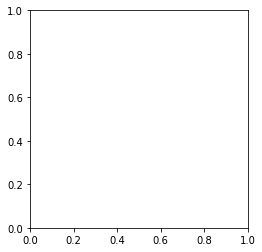

In [0]:
# Light Data Exploration
gdf.crs
type(gdf)
gdf.columns
gdf.head()
gdf.plot()
# Ensure your aggregation is correctly set for the crosswalk to work.

# Lets make a GIF

Reading in the Names Crosswalk with a URL. 

We will Read in our Boundaries Crosswalk next.

In [0]:
# Names Crosswalk.
evanston = '2PACX-1vSIJpLSmdQkvqJ3Wk6ONJmj_qHBgG_1naDxd0KcNyrT2LoJhqhoRSMtY1kyjy__xZ4Y8UN-tMNNAUa-'
baltComm = '2PACX-1vREwwa_s8Ix39OYGnnS_wA8flOoEkU7reIV4o3ZhlwYhLXhpNEvnOia_uHUDBvnFptkLLHHlaQNvsQE'
url = 'https://docs.google.com/spreadsheets/d/e/' + evanston + '/pub?output=csv' 
namesCw = pd.read_csv( url )
namesCw.columns
namesCw.head()

Index(['OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'created_user', 'created_date',
       'last_edited_user', 'last_edited_date', 'GEOID10num', 'Tract10Num',
       'ShapeSTArea', 'ShapeSTLength', 'geometry'],
      dtype='object')

,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,created_user,created_date,last_edited_user,last_edited_date,GEOID10num,Tract10Num,ShapeSTArea,ShapeSTLength,geometry
0,19,17,31,809600,17031809600,8096.0,Census Tract 8096,G5020,S,1300137,0,42.044745,-87.699904,NaN,NaN,MVARNER,2019-05-01T21:06:24,17031809600,809600,1.398329e+07,15853.66701,POLYGON ((-87.70...
1,20,17,31,809700,17031809700,8097.0,Census Tract 8097,G5020,S,1323073,0,42.037466,-87.699915,NaN,NaN,MVARNER,2019-05-01T21:06:24,17031809700,809700,1.422420e+07,16063.03870,POLYGON ((-87.70...
2,21,17,31,809800,17031809800,8098.0,Census Tract 8098,G5020,S,597774,0,42.037529,-87.685499,NaN,NaN,MVARNER,2019-05-01T21:06:24,17031809800,809800,6.388610e+06,10293.09649,POLYGON ((-87.69...
3,22,17,31,809900,17031809900,8099.0,Census Tract 8099,G5020,S,765553,0,42.037619,-87.675263,NaN,NaN,MVARNER,2019-05-01T21:06:24,17031809900,809900,8.357456e+06,12018.23198,POLYGON ((-87.67...
4,23,17,31,810000,17031810000,8100.0,Census Tract 8100,G5020,S,1108649,1422820,42.024770,-87.669119,NaN,NaN,MVARNER,2019-05-01T21:06:24,17031810000,810000,1.231487e+07,14882.37133,POLYGON ((-87.67...


Reading in the Boundary Data with a filePath. We specify the geometry on import this time.

Index(['OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'created_user', 'created_date',
       'last_edited_user', 'last_edited_date', 'GEOID10num', 'Tract10Num',
       'ShapeSTArea', 'ShapeSTLength', 'geometry'],
      dtype='object')

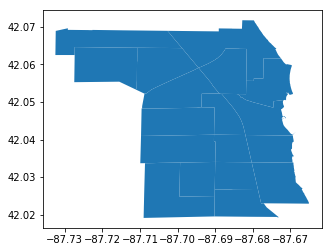

In [0]:
# Boundary Crosswalk
evanston = '2PACX-1vSIJpLSmdQkvqJ3Wk6ONJmj_qHBgG_1naDxd0KcNyrT2LoJhqhoRSMtY1kyjy__xZ4Y8UN-tMNNAUa-'
url = 'https://docs.google.com/spreadsheets/d/e/' + evanston + '/pub?output=csv' 
boundsCw = pd.read_csv(url)
boundsCw['geometry'] = boundsCw['geometry'].apply(lambda x: loads( str(x) ))
boundsCw = GeoDataFrame(boundsCw, geometry='geometry')

# file = findFile('../', 'boundaries-evanston-tracts-2010.geojson')
#boundsCw = gpd.read_file(file, geometry='geometry')
boundsCw.columns
boundsCw.plot()

Settings for the data we will pull

In [0]:
# Lets put it all together now! For Cook County, Illinois
state = '17'
county = '031' 
tract = '*'
tableId = 'B08303'
years = ['17','16', '15']
saveAcs = True
numer = ['001', '002', '003']
denom = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011' ]

saveAcs = True
saveCw1 = True
cwlk1FileName = 'Example_NamedCrosswalk.csv'
saveCw2 = True
cwlk2FileName = 'Example_BoundaryCrosswalk.csv'

groupBy = False
#groupBy = 'CSA2010'
aggMethod = 'sum'

namesCw = namesCw
names_local_match_col = 'tract'
names_foreign_match_col = 'Tract10Num'
names_foreign_wanted_col = 'INTPTLAT10'

boundsCw = boundsCw
bounds_local_match_col = 'tract'
bounds_foreign_match_col = 'Tract10Num'
bounds_foreign_wanted_col = 'geometry'

In [0]:
# Download a multiple years of estimates and merge them
def getAcsYears(state, county, tract, years, 
                tableId, numer, denom, 
                namesCw, lcw1Match, fcw1Match, fcw1Want, groupBy, aggMethod,
                boundsCw, lcw2Match, fcw2Match, fcw2Want, 
                saveAcs, saveCw1, cwlk1FileName, saveCw2, cwlk2FileName):
  # Get the data
  count = 0
  final = ''
  for year in years:
    df = retrieve_acs_data(state, county, tract, tableId, year, saveAcs)
    if numer and denom:
      # Numerators 
      numerators = pd.DataFrame()
      for colSubString in numer:
        colName = list(filter(lambda x: colSubString in x, df.columns))[0] 
        numerators = addKey(df, numerators, colName)
      # Denominators
      denominators = pd.DataFrame()
      for colSubString in denom:
        colName = list(filter(lambda x: colSubString in x, df.columns))[0] 
        denominators = addKey(df, denominators, colName)
      # Run the Calculation 
      fi = pd.DataFrame()
      df['numerator'] = numerators.sum(axis=1)
      df['denominator'] = denominators.sum(axis=1)
      df = df[df['denominator'] != 0] # Delete Rows where the 'denominator' column is 0
      df['final'] = (df['numerator'] / df['denominator'] ) * 100
    df = df.add_prefix('20'+year+'_')
    newTract = '20'+year+'_tract'
    df = df.rename(columns={newTract: 'tract'} )
    if count == 0: count = count+1; final = df
    else: final = final.merge(df, on='tract')
    print('Table: ' + tableId + ', Year: ' + year + ' recieved.')
  print('Download Complete')
  
  # Merge crosswalk with the Names data
  if isinstance(namesCw, pd.DataFrame):
    print('local boundary crosswalk matching on '+lcw2Match)
    print('foreign boundary crosswalk matching on '+fcw2Match)
    print('Pulling from foreign boundary crosswalk '+fcw2Want+' with Columns')
    final = crosswalkIt( namesCw, final, lcw1Match, fcw1Match, fcw1Want, saveCw1, cwlk1FileName )

  # Group and Aggregate 
  if groupBy:
    df = df.groupby(groupBy)
    print('Grouped')
    if aggMethod == 'sum':
      df = sumInts(df)
    else:
      df = sumInts(df)
    print('Aggregated')
    
  # Merge crosswalk with the Geom data
  print('local boundary crosswalk matching on '+lcw2Match)
  print('foreign boundary crosswalk matching on '+fcw2Match)
  print('Pulling from foreign boundary crosswalk '+fcw2Want+' with Columns')
  print(boundsCw.columns)
  final = crosswalkIt( boundsCw, final, lcw2Match, fcw2Match, fcw2Want, saveCw2, cwlk2FileName )
  final = GeoDataFrame(final, geometry=fcw2Want)
  
  return final

Number of Columns 13
Table: B08303, Year: 17 recieved.
Number of Columns 13
Table: B08303, Year: 16 recieved.
Number of Columns 13
Table: B08303, Year: 15 recieved.
Download Complete
local boundary crosswalk matching on tract
foreign boundary crosswalk matching on Tract10Num
Pulling from foreign boundary crosswalk geometry with Columns
Local Column Values Not Matched 
[ 10000  10100  10201 ... 843700 843800 843900]
1298

Crosswalk Unique Column Values
[809600 809700 809800 809900 810000 810100 810200 810301 810302 808702
 808800 808900 809000 809100 809200 809300 809400 809500]
SavingCrosswalk
Example_NamedCrosswalk.csv
local boundary crosswalk matching on tract
foreign boundary crosswalk matching on Tract10Num
Pulling from foreign boundary crosswalk geometry with Columns
Index(['OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'created_user', 'created_date',
 

Index(['2017_B08303_001E_Total', '2017_B08303_002E_Total_Less_than_5_minutes',
       '2017_B08303_003E_Total_5_to_9_minutes',
       '2017_B08303_004E_Total_10_to_14_minutes',
       '2017_B08303_005E_Total_15_to_19_minutes',
       '2017_B08303_006E_Total_20_to_24_minutes',
       '2017_B08303_007E_Total_25_to_29_minutes',
       '2017_B08303_008E_Total_30_to_34_minutes',
       '2017_B08303_009E_Total_35_to_39_minutes',
       '2017_B08303_010E_Total_40_to_44_minutes',
       '2017_B08303_011E_Total_45_to_59_minutes',
       '2017_B08303_012E_Total_60_to_89_minutes',
       '2017_B08303_013E_Total_90_or_more_minutes', '2017_state',
       '2017_county', 'tract', '2017_numerator', '2017_denominator',
       '2017_final', '2016_B08303_001E_Total',
       '2016_B08303_002E_Total_Less_than_5_minutes',
       '2016_B08303_003E_Total_5_to_9_minutes',
       '2016_B08303_004E_Total_10_to_14_minutes',
       '2016_B08303_005E_Total_15_to_19_minutes',
       '2016_B08303_006E_Total_20_to_24_

,2017_B08303_001E_Total,2017_B08303_002E_Total_Less_than_5_minutes,2017_B08303_003E_Total_5_to_9_minutes,2017_B08303_004E_Total_10_to_14_minutes,2017_B08303_005E_Total_15_to_19_minutes,2017_B08303_006E_Total_20_to_24_minutes,2017_B08303_007E_Total_25_to_29_minutes,2017_B08303_008E_Total_30_to_34_minutes,2017_B08303_009E_Total_35_to_39_minutes,2017_B08303_010E_Total_40_to_44_minutes,2017_B08303_011E_Total_45_to_59_minutes,2017_B08303_012E_Total_60_to_89_minutes,2017_B08303_013E_Total_90_or_more_minutes,2017_state,2017_county,tract,2017_numerator,2017_denominator,2017_final,2016_B08303_001E_Total,2016_B08303_002E_Total_Less_than_5_minutes,2016_B08303_003E_Total_5_to_9_minutes,2016_B08303_004E_Total_10_to_14_minutes,2016_B08303_005E_Total_15_to_19_minutes,2016_B08303_006E_Total_20_to_24_minutes,2016_B08303_007E_Total_25_to_29_minutes,2016_B08303_008E_Total_30_to_34_minutes,2016_B08303_009E_Total_35_to_39_minutes,2016_B08303_010E_Total_40_to_44_minutes,2016_B08303_011E_Total_45_to_59_minutes,2016_B08303_012E_Total_60_to_89_minutes,2016_B08303_013E_Total_90_or_more_minutes,2016_state,2016_county,2016_numerator,2016_denominator,2016_final,2015_B08303_001E_Total,2015_B08303_002E_Total_Less_than_5_minutes,2015_B08303_003E_Total_5_to_9_minutes,2015_B08303_004E_Total_10_to_14_minutes,2015_B08303_005E_Total_15_to_19_minutes,2015_B08303_006E_Total_20_to_24_minutes,2015_B08303_007E_Total_25_to_29_minutes,2015_B08303_008E_Total_30_to_34_minutes,2015_B08303_009E_Total_35_to_39_minutes,2015_B08303_010E_Total_40_to_44_minutes,2015_B08303_011E_Total_45_to_59_minutes,2015_B08303_012E_Total_60_to_89_minutes,2015_B08303_013E_Total_90_or_more_minutes,2015_state,2015_county,2015_numerator,2015_denominator,2015_final,INTPTLAT10,geometry
166,3143,0,25,205,298,443,322,292,207,238,368,667,78,17,31,810200,3143,4728,66.476311,3012,41,48,255,371,387,340,245,221,260,360,425,59,17,31,3012,4699,64.098744,2846,44,26,276,368,370,260,287,80,212,375,480,68,17,31,2846,4477,63.569354,42.022822,POLYGON ((-87.69...
428,1949,36,187,236,356,237,103,194,9,126,168,208,89,17,31,809400,1949,3298,59.096422,2061,31,243,357,395,185,79,175,23,126,225,160,62,17,31,2061,3526,58.451503,1963,22,186,336,357,128,80,204,20,133,250,182,65,17,31,1963,3276,59.920635,42.044784,POLYGON ((-87.67...
435,1523,21,72,212,133,73,7,95,108,159,389,198,56,17,31,809900,1523,2136,71.301498,1645,19,51,236,145,89,16,113,96,129,475,218,58,17,31,1645,2314,71.089023,1595,6,52,207,217,82,65,129,51,56,462,212,56,17,31,1595,2353,67.785805,42.037619,POLYGON ((-87.67...
565,1565,15,145,127,269,162,27,107,45,113,280,246,29,17,31,809100,1565,2417,64.749690,1552,40,165,112,264,199,3,99,43,119,258,207,43,17,31,1552,2434,63.763353,1496,43,197,143,278,143,2,83,28,81,247,200,51,17,31,1496,2385,62.725367,42.059352,POLYGON ((-87.71...
568,1553,57,118,121,203,127,88,150,34,75,310,259,11,17,31,809000,1553,2417,64.253206,1512,61,126,136,190,139,87,102,31,78,321,225,16,17,31,1512,2353,64.258394,1583,66,118,179,207,190,96,102,26,80,293,210,16,17,31,1583,2541,62.298308,42.059755,POLYGON ((-87.72...


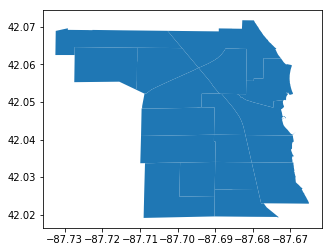

In [0]:
fnl = getAcsYears(state, county, tract, years, tableId, numer, denom, 
                  namesCw, names_local_match_col, names_foreign_match_col, names_foreign_wanted_col, groupBy, aggMethod,
                  boundsCw, bounds_local_match_col, bounds_foreign_match_col, bounds_foreign_wanted_col, 
                  saveAcs, saveCw1, cwlk1FileName, saveCw2, cwlk2FileName)
fnl.plot()
fnl.columns
fnl.head()

Data was successfully merged across all years and geometry.

Now we want the tractname, geometry, and the specific column we want to make a gif from.

In [0]:
# Get only the results tab
td = fnl.filter(regex="final|tract|geometry")
td = td.reindex(sorted(td.columns), axis=1)
td.head()

# Get Min Max
mins = []
maxs = []
for col in td.columns:
  if col in ['NAME', 'state', 'county', 'tract', 'geometry'] :
    pass
  else: 
    mins.append(td[col].min())
    maxs.append(td[col].max())
print(mins, maxs)

# set the min and max range for the choropleth map
vmin, vmax = min(mins), max(maxs)

,2015_final,2016_final,2017_final,geometry,tract
166,63.569354,64.098744,66.476311,POLYGON ((-87.69...,810200
428,59.920635,58.451503,59.096422,POLYGON ((-87.67...,809400
435,67.785805,71.089023,71.301498,POLYGON ((-87.67...,809900
565,62.725367,63.763353,64.749690,POLYGON ((-87.71...,809100
568,62.298308,64.258394,64.253206,POLYGON ((-87.72...,809000


[53.71589840075258, 53.786342123056116, 54.01844532279315] [67.78580535486613, 71.08902333621435, 71.30149812734082]


In [0]:
merged = td   
fileNames = []
annotation = 'Source: Baltimore Neighborhood Indicators Allianace - Jacob France Institute, 2019'
saveGifAs = './TESTGIF.gif'
labelBounds = True
specialLabelCol = False
# For each column
for indx, col in enumerate(merged.columns):
    if col in ['NAME', 'state', 'county', 'tract', 'geometry'] :
        pass
    else: 
        print('Col Index: ', indx)
        print('Col Name: '+str(col) )

        # create map, UDPATE: added plt.Normalize to keep the legend range the same for all maps
        fig = merged.plot(column=col, cmap='Blues', figsize=(10,10), 
           linewidth=0.8, edgecolor='0.8', vmin=vmin, vmax=vmax,
           legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax) 
        )
        print('Fig Created')
        
        # https://stackoverflow.com/questions/38899190/geopandas-label-polygons
        if labelBounds:
          labelColumn = col
          if specialLabelCol: labelColumn = specialLabelCol
          merged.apply(lambda x: fig.annotate(s=x[labelColumn], xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
        
        # remove axis of chart and set title
        fig.axis('off')
        col = col.replace("_final", "").replace("_", " ")
        # str(col.replace("_", " ")[12:])
        fig.set_title(str(col), fontdict={'fontsize': '10', 'fontweight' : '3'})
        print('Fig Titled')
        
        # create an annotation for the  data source
        fig.annotate(annotation,
               xy=(0.1, .08), xycoords='figure fraction',
               horizontalalignment='left', verticalalignment='top',
               fontsize=10, color='#555555')
        print('Fig annotated')
        
        # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
        # filepath = os.path.join(output_path, image_name)
        image_name = 'test_'+col+'.jpg'
        fileNames.append(image_name)
        chart = fig.get_figure()
        # fig.savefig(“map_export.png”, dpi=300)
        chart.savefig(image_name, dpi=300)
        plt.close(chart)
        
images = []
for filename in fileNames:
    images.append(imageio.imread(filename))
imageio.mimsave(saveGifAs, images, fps=.5)

Col Index:  0
Col Name: 2015_final
Fig Created


166     Annotation(-87.6...
428     Annotation(-87.6...
435     Annotation(-87.6...
565     Annotation(-87.7...
568     Annotation(-87.7...
569     Annotation(-87.6...
648     Annotation(-87.6...
965     Annotation(-87.6...
1047    Annotation(-87.6...
1075    Annotation(-87.7...
1076    Annotation(-87.6...
1077    Annotation(-87.6...
1078    Annotation(-87.7...
1093    Annotation(-87.6...
1174    Annotation(-87.6...
1271    Annotation(-87.6...
1303    Annotation(-87.6...
1304    Annotation(-87.6...
dtype: object

(-87.73588219621746, -87.66163225165677, 42.01650811684183, 42.07438709638502)

Text(0.5, 1.0, '2015')

Fig Titled


Text(0.1, 0.08, 'Source: Baltimore Neighborhood Indicators Allianace - Jacob France Institute, 2019')

Fig annotated
Col Index:  1
Col Name: 2016_final
Fig Created


166     Annotation(-87.6...
428     Annotation(-87.6...
435     Annotation(-87.6...
565     Annotation(-87.7...
568     Annotation(-87.7...
569     Annotation(-87.6...
648     Annotation(-87.6...
965     Annotation(-87.6...
1047    Annotation(-87.6...
1075    Annotation(-87.7...
1076    Annotation(-87.6...
1077    Annotation(-87.6...
1078    Annotation(-87.7...
1093    Annotation(-87.6...
1174    Annotation(-87.6...
1271    Annotation(-87.6...
1303    Annotation(-87.6...
1304    Annotation(-87.6...
dtype: object

(-87.73588219621746, -87.66163225165677, 42.01650811684183, 42.07438709638502)

Text(0.5, 1.0, '2016')

Fig Titled


Text(0.1, 0.08, 'Source: Baltimore Neighborhood Indicators Allianace - Jacob France Institute, 2019')

Fig annotated
Col Index:  2
Col Name: 2017_final
Fig Created


166     Annotation(-87.6...
428     Annotation(-87.6...
435     Annotation(-87.6...
565     Annotation(-87.7...
568     Annotation(-87.7...
569     Annotation(-87.6...
648     Annotation(-87.6...
965     Annotation(-87.6...
1047    Annotation(-87.6...
1075    Annotation(-87.7...
1076    Annotation(-87.6...
1077    Annotation(-87.6...
1078    Annotation(-87.7...
1093    Annotation(-87.6...
1174    Annotation(-87.6...
1271    Annotation(-87.6...
1303    Annotation(-87.6...
1304    Annotation(-87.6...
dtype: object

(-87.73588219621746, -87.66163225165677, 42.01650811684183, 42.07438709638502)

Text(0.5, 1.0, '2017')

Fig Titled


Text(0.1, 0.08, 'Source: Baltimore Neighborhood Indicators Allianace - Jacob France Institute, 2019')

Fig annotated


# Optional: Prepair Google Drive Data Folder/ Drive Import Operations

Access Google Drive directories:

In [0]:
#https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.05-IPython-And-Shell-Commands.ipynb

from google.colab import drive
drive.mount("/content/drive")

You can also import file directly into a temporary folder in a public folder

In [0]:
#Import Data (data.csv file)
from google.colab import files

# Just uncommment this line and run the cell
# uploaded = files.upload()

Now lets explore the file system using the built in terminal:

By default you are positioned in the ./content/ folder.

In [0]:
# From the /content folder, I navigate to my Drive Data Folder 
cd ./drive/My Drive/colabs/DATA

/content/drive/My Drive/colabs/DATA


In [0]:
ls

 avocado.csv
 baltimore-births/
 boundaries-baltimore-communities-NoWater-2010.geojson
 boundaries-baltimore-neighborhoods.csv
 boundaries-baltimore-neighborhoods.geojson
 boundaries-baltimore-neighborhoods.json
 boundaries--baltimore-tracts-NoWater-2010.geojson
 boundaries-evanston-tracts-2010.csv
 boundaries-evanston-tracts-2010.geojson
 boundaries-evanston-tracts-2010.gsheet
 boundaries-maryland_census-tracts-2010.csv
 boundaries-maryland_census-tracts-2010.geojson
 boundaries-maryland-counties.csv
 boundaries-maryland-counties.geojson
 boundaries-moco-census-tracts-2010.csv
 boundaries-moco-census-tracts-2010.geojson
 crosswalk-census-communities-2010.gsheet
 crosswalk-matched-CSA2010-to-CSA-pulling-geometry.csv
 crosswalk-matched-tract-to-TRACT2010-pulling-CSA2010.csv
 crosswalk-matched-tract-to-TRACTCE10-pulling-geometry.csv
 dashboardDataColumnDescriptions.csv
 dashboardDataColumnDescriptions.gsheet
 dashboardData.csv
 dashboardData.gsheet
 exemptions/
'Grid view.csv'
 iw.csv


In [0]:
# And now (for fun) I want to list out all the geojson files in the folder
for file in os.listdir("./"):
    if file.endswith(".geojson"):
        print(file)

boundaries-evanston-tracts-2010.geojson
boundaries-moco-census-tracts-2010.geojson
boundaries-maryland-counties.geojson
boundaries-maryland_census-tracts-2010.geojson
boundaries-baltimore-neighborhoods.geojson
boundaries-baltimore-communities-NoWater-2010.geojson
boundaries--baltimore-tracts-NoWater-2010.geojson


The next two function will help navigating the file directories: 
- findFile(): Find a Relative Path to a File given its filename
- addPath(): To 'import' a script you wrote, you must first map its filepath into the sys. 
- The addPath() function uses findFile() and accepts a filename as its parameter.

In [0]:
# @title Run This Cell: addPath() findFile()
    
# Find Relative Path to Files
def findFile(root, file):
    for d, subD, f in os.walk(root):
        if file in f:
            return "{1}/{0}".format(file, d)
            break 

# To 'import' a script you wrote, map its filepath into the sys
def addPath(root, file): sys.path.append(os.path.abspath( findFile( './', file) ))